## Task 3 Part e)

In [4]:
import os
import re
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, NMF
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import librosa
import librosa.display
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     Hostname mismatch, certificate is not valid for
[nltk_data]     'raw.githubusercontent.com'. (_ssl.c:1006)>
[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     Hostname mismatch, certificate is not valid for
[nltk_data]     'raw.githubusercontent.com'. (_ssl.c:1006)>
[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     Hostname mismatch, certificate is not valid for
[nltk_data]     'raw.githubusercontent.com'. (_ssl.c:1006)>


False

In [9]:
BASE_DIR = r"C:\Users\Rishita\Desktop\MMDP-Assignment-change\Task3_a"
ANTHEM_IMAGES_DIR = f"{BASE_DIR}/svg"
ANTHEM_AUDIO_DIR = f"{BASE_DIR}/nationalanthems_audio"
ANTHEM_TEXT_DIR = f"{BASE_DIR}/anthem_translations"
RESULTS_DIR = r"C:\Users\Rishita\Desktop\MMDP-Assignment-change\Task3_e"

In [19]:
def analyze_multimodal_correlations():
    """
    Analyze correlations between the three modalities of national anthems:
    1. Text (words and themes from anthem lyrics)
    2. Visual (SVG images - likely flags or national symbols)
    3. Audio (MP3 files - anthem recordings)
    """
    print("\n--- MULTIMODAL CORRELATION ANALYSIS ---")
    
    # Load data from all three modalities
    anthem_texts = load_anthem_texts()  # Already implemented
    anthem_images = load_anthem_images()
    anthem_audio = load_anthem_audio()
    
    # Get intersection of countries that have all three modalities
    common_countries = set(anthem_texts.keys()) & set(anthem_images.keys()) & set(anthem_audio.keys())
    print(f"Found {len(common_countries)} countries with all three modalities (text, image, audio)")
    
    if len(common_countries) < 5:
        print("Not enough countries with all modalities for meaningful correlation analysis.")
        return
    
    # Create a combined DataFrame for correlation analysis
    correlation_df = pd.DataFrame(index=list(common_countries))
    
    # Add text features
    text_features = extract_text_features(anthem_texts, common_countries)
    for feature_name, feature_values in text_features.items():
        print("text feature name: ", feature_name)
        correlation_df[f"text_{feature_name}"] = pd.Series(feature_values)
    
    # Add image features
    image_features = extract_image_features(anthem_images, common_countries)
    for feature_name, feature_values in image_features.items():
        print("image feature name: ", feature_name)
        correlation_df[f"image_{feature_name}"] = pd.Series(feature_values)
    
    # Add audio features
    audio_features = extract_audio_features(anthem_audio, common_countries)
    for feature_name, feature_values in audio_features.items():
        print("audio Feature Name: ", feature_name)
        correlation_df[f"audio_{feature_name}"] = pd.Series(feature_values)
    
    # Save the combined features
    correlation_df.to_csv(os.path.join(RESULTS_DIR, 'multimodal_features.csv'))
    print("Correlation df saved")
    
    # Calculate correlation matrix
    correlation_matrix = correlation_df.corr()
    
    # Save correlation matrix
    correlation_matrix.to_csv(os.path.join(RESULTS_DIR, 'multimodal_correlation_matrix.csv'))
    
    # Visualize correlation matrix
    plt.figure(figsize=(16, 14))
    sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
    plt.title('Correlation Matrix between Modalities')
    plt.tight_layout()
    plt.show()
    plt.savefig(os.path.join(RESULTS_DIR, 'multimodal_correlation_heatmap.png'))
    
    # Extract cross-modal correlations specifically
    cross_modal_corr = extract_cross_modal_correlations(correlation_matrix)
    
    # Visualize top cross-modal correlations
    visualize_top_correlations(cross_modal_corr, correlation_df, common_countries)
    
    # Cluster countries based on multimodal features
    cluster_multimodal_data(correlation_df)
    
    # Cross-modal prediction experiments
    run_cross_modal_prediction(correlation_df)
    
    return correlation_df, correlation_matrix


def load_anthem_texts():
    """Load all anthem text files into a dictionary."""
    anthem_texts = {}
    
    for files in os.listdir(ANTHEM_TEXT_DIR):
        if not files.endswith('.txt'):
            continue  # Skip non-text files
            
        country_name = files.replace('.txt', '')
        file_path = os.path.join(ANTHEM_TEXT_DIR, files)
        print("file path: ", file_path)
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                text = f.read()
                print("text: ", text)
                # Skip empty text files
                if text.strip():
                    anthem_texts[country_name] = text
                    print("Country Name: ", country_name)
                    print("First 100 chars of text: ", text[:100] + "..." if len(text) > 100 else text)
                else:
                    print(f"Skipping {country_name}: empty text file")
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
    
    print(f"Loaded {len(anthem_texts)} anthem text files.")
    return anthem_texts

def load_anthem_images():
    """Load and process SVG images of national symbols/flags."""
    anthem_images = {}
    
    # Look for SVG files in the image directory
    IMAGE_DIR = ANTHEM_IMAGES_DIR
    print("image dir: ", IMAGE_DIR)
    
    if not os.path.exists(IMAGE_DIR):
        print(f"Image directory not found: {IMAGE_DIR}")
        return anthem_images
    
    for files in os.listdir(IMAGE_DIR):
        file_path = os.path.join(IMAGE_DIR, files)
        country_name = os.path.basename(file_path).replace('.svg', '')
        try:
            # For SVG files, we'll just store the path and extract features later
            anthem_images[country_name] = file_path
            print(f"Loaded image for {country_name}")
        except Exception as e:
            print(f"Error loading image {file_path}: {e}")
    
    print(f"Loaded {len(anthem_images)} anthem images.")
    return anthem_images

def load_anthem_audio():
    """Load and process MP3 audio of national anthems."""
    anthem_audio = {}
    
    # Look for MP3 files in the audio directory
    AUDIO_DIR = ANTHEM_AUDIO_DIR
    print("audio dir: ", AUDIO_DIR)
    
    if not os.path.exists(AUDIO_DIR):
        print(f"Audio directory not found: {AUDIO_DIR}")
        return anthem_audio
    
    for files in os.listdir(AUDIO_DIR):
        file_path = os.path.join(AUDIO_DIR, files)
        country_name = os.path.basename(file_path).replace('.mp3', '')
        print("file path: ", file_path)
        try:
            # For MP3 files, we'll just store the path and extract features later
            anthem_audio[country_name] = file_path
            print(f"Loaded audio for {country_name}")
        except Exception as e:
            print(f"Error loading audio {file_path}: {e}")
    
    print(f"Loaded {len(anthem_audio)} anthem audio files.")
    return anthem_audio

def extract_text_features(anthem_texts, common_countries):
    """Extract features from anthem texts."""
    print("entered extract_text_features")
    features = {}
    
    # 1. Text length (word count)
    features['length'] = {country: len(anthem_texts[country].split()) 
                           for country in common_countries if country in anthem_texts}
    
    # 2. Sentiment analysis
    from textblob import TextBlob
    
    features['sentiment_polarity'] = {}
    features['sentiment_subjectivity'] = {}
    
    for country in common_countries:
        if country in anthem_texts:
            blob = TextBlob(anthem_texts[country])
            features['sentiment_polarity'][country] = blob.sentiment.polarity
            features['sentiment_subjectivity'][country] = blob.sentiment.subjectivity
    
    # 3. Theme detection (using keyword counting)
    theme_keywords = {
        'patriotism': ['nation', 'country', 'homeland', 'patriot', 'loyal', 'pride', 'proud'],
        'freedom': ['free', 'liberty', 'independence', 'sovereign'],
        'war': ['war', 'battle', 'fight', 'enemy', 'victory', 'defeat', 'soldier', 'army'],
        'peace': ['peace', 'harmony', 'unity', 'together', 'brotherhood'],
        'nature': ['mountain', 'river', 'sea', 'land', 'earth', 'sky', 'sun', 'star', 'moon'],
        'religion': ['god', 'divine', 'holy', 'heaven', 'faith', 'prayer', 'blessing']
    }
    
    # Process themes
    for theme, keywords in theme_keywords.items():
        features[f'theme_{theme}'] = {}
        
        for country in common_countries:
            if country in anthem_texts:
                text = anthem_texts[country].lower()
                # Count keyword occurrences
                count = sum(text.count(keyword) for keyword in keywords)
                # Normalize by text length
                text_length = len(text.split())
                features[f'theme_{theme}'][country] = count / max(1, text_length) * 100
    
    return features

def extract_image_features(anthem_images, common_countries):
    """Extract features from SVG images."""
    print("Entered extract_image_features")
    features = {}
    
    # For SVG images, we'll analyze color and complexity
    
    # 1. Color analysis
    features['color_count'] = {}
    features['red_dominance'] = {}
    features['green_dominance'] = {}
    features['blue_dominance'] = {}
    features['brightness'] = {}
    
    # 2. Image complexity
    features['complexity'] = {}
    
    try:
        # Only import these if we're processing images
        import xml.etree.ElementTree as ET
        import colorsys
        import re
        
        def extract_colors_from_svg(svg_file):
            """Extract color information from SVG file."""
            print("SVG file: ", svg_file)
            try:
                tree = ET.parse(svg_file)
                root = tree.getroot()
                
                # Extract all color values (fill, stroke, etc.)
                colors = []
                color_pattern = re.compile(r'#[0-9a-fA-F]{3,6}')
                
                # Convert the entire XML to string for regex search
                xml_str = ET.tostring(root, encoding='unicode')
                color_matches = color_pattern.findall(xml_str)
                
                # Also look for rgb() and rgba() values
                rgb_pattern = re.compile(r'rgb\(\s*(\d+)\s*,\s*(\d+)\s*,\s*(\d+)\s*\)')
                rgb_matches = rgb_pattern.findall(xml_str)
                
                # Add hex colors
                colors.extend(color_matches)
                
                # Add RGB colors converted to hex
                for r, g, b in rgb_matches:
                    hex_color = f'#{int(r):02x}{int(g):02x}{int(b):02x}'
                    colors.append(hex_color)
                
                return colors
            except Exception as e:
                print(f"Error extracting colors from {svg_file}: {e}")
                return []
        
        def analyze_colors(colors):
            """Analyze a list of color values."""
            if not colors:
                return {
                    'count': 0,
                    'red': 0,
                    'green': 0,
                    'blue': 0,
                    'brightness': 0
                }
            
            # Parse hex colors
            rgb_values = []
            for color in colors:
                if color.startswith('#'):
                    if len(color) == 4:  # Short form #RGB
                        r = int(color[1] + color[1], 16)
                        g = int(color[2] + color[2], 16)
                        b = int(color[3] + color[3], 16)
                    else:  # Long form #RRGGBB
                        r = int(color[1:3], 16)
                        g = int(color[3:5], 16)
                        b = int(color[5:7], 16)
                    rgb_values.append((r, g, b))
            
            # Calculate metrics
            color_count = len(set(colors))
            
            # Calculate color dominance
            total_r = sum(r for r, _, _ in rgb_values)
            total_g = sum(g for _, g, _ in rgb_values)
            total_b = sum(b for _, _, b in rgb_values)
            total = total_r + total_g + total_b
            
            if total == 0:
                red_dom = green_dom = blue_dom = 0
            else:
                red_dom = total_r / total
                green_dom = total_g / total
                blue_dom = total_b / total
            
            # Calculate average brightness
            brightness = sum((r + g + b) / 3 for r, g, b in rgb_values) / max(1, len(rgb_values)) / 255
            
            return {
                'count': color_count,
                'red': red_dom,
                'green': green_dom,
                'blue': blue_dom,
                'brightness': brightness
            }
        
        def measure_svg_complexity(svg_file):
            """Measure the complexity of an SVG file."""
            try:
                # Count the number of elements as a proxy for complexity
                tree = ET.parse(svg_file)
                root = tree.getroot()
                
                # Count all elements
                element_count = len(root.findall('.//*'))
                
                # Get file size as another complexity measure
                file_size = os.path.getsize(svg_file)
                
                # Combine metrics
                complexity = (element_count * file_size) ** 0.5  # Geometric mean
                
                return complexity
            except Exception as e:
                print(f"Error measuring complexity of {svg_file}: {e}")
                return 0
        
        # Process each image
        for country in common_countries:
            if country in anthem_images:
                svg_file = anthem_images[country]
                
                # Extract colors
                colors = extract_colors_from_svg(svg_file)
                color_analysis = analyze_colors(colors)
                
                # Store features
                features['color_count'][country] = color_analysis['count']
                features['red_dominance'][country] = color_analysis['red']
                features['green_dominance'][country] = color_analysis['green']
                features['blue_dominance'][country] = color_analysis['blue']
                features['brightness'][country] = color_analysis['brightness']
                
                # Measure complexity
                complexity = measure_svg_complexity(svg_file)
                features['complexity'][country] = complexity
    
    except ImportError as e:
        print(f"Warning: Could not import libraries for image analysis: {e}")
        # Fill with dummy values if imports fail
        for country in common_countries:
            if country in anthem_images:
                features['color_count'][country] = 0
                features['red_dominance'][country] = 0
                features['green_dominance'][country] = 0
                features['blue_dominance'][country] = 0
                features['brightness'][country] = 0
                features['complexity'][country] = 0
    
    return features

def extract_audio_features(anthem_audio, common_countries):
    """Extract features from MP3 audio files."""
    print("Entered extract_audio_features")
    features = {}
    
    # Initialize feature dictionaries
    features['duration'] = {}
    features['tempo'] = {}
    features['energy'] = {}
    features['pitch_mean'] = {}
    features['pitch_std'] = {}
    features['volume'] = {}
    
    try:
        # Only import if we're processing audio
        import librosa
        import numpy as np
        
        def analyze_audio(audio_file):
            """Extract audio features using librosa."""
            try:
                # Load audio file
                print("audio file: ", audio_file)
                y, sr = librosa.load(audio_file, sr=None)
                
                # Duration
                duration = librosa.get_duration(y=y, sr=sr)
                
                # Tempo estimation
                onset_env = librosa.onset.onset_strength(y=y, sr=sr)
                tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)[0]
                
                # Energy (RMS)
                rms = librosa.feature.rms(y=y)[0]
                energy = np.mean(rms)
                
                # Pitch features
                pitches, magnitudes = librosa.core.piptrack(y=y, sr=sr)
                pitches = pitches[magnitudes > np.median(magnitudes)]
                pitch_mean = np.mean(pitches) if len(pitches) > 0 else 0
                pitch_std = np.std(pitches) if len(pitches) > 0 else 0
                
                # Volume
                volume = np.mean(np.abs(y))
                
                return {
                    'duration': duration,
                    'tempo': tempo,
                    'energy': energy,
                    'pitch_mean': pitch_mean,
                    'pitch_std': pitch_std,
                    'volume': volume
                }
            except Exception as e:
                print(f"Error analyzing audio {audio_file}: {e}")
                return {
                    'duration': 0,
                    'tempo': 0,
                    'energy': 0,
                    'pitch_mean': 0,
                    'pitch_std': 0,
                    'volume': 0
                }
        
        # Process each audio file
        for country in common_countries:
            if country in anthem_audio:
                audio_file = anthem_audio[country]
                
                # Extract audio features
                audio_analysis = analyze_audio(audio_file)
                
                # Store features
                features['duration'][country] = audio_analysis['duration']
                features['tempo'][country] = audio_analysis['tempo']
                features['energy'][country] = audio_analysis['energy']
                features['pitch_mean'][country] = audio_analysis['pitch_mean']
                features['pitch_std'][country] = audio_analysis['pitch_std']
                features['volume'][country] = audio_analysis['volume']
    
    except ImportError as e:
        print(f"Warning: Could not import libraries for audio analysis: {e}")
        # Fill with dummy values if imports fail
        for country in common_countries:
            if country in anthem_audio:
                features['duration'][country] = 0
                features['tempo'][country] = 0
                features['energy'][country] = 0
                features['pitch_mean'][country] = 0
                features['pitch_std'][country] = 0
                features['volume'][country] = 0
    
    return features

def extract_cross_modal_correlations(correlation_matrix):
    """Extract correlations between different modalities."""
    text_features = [col for col in correlation_matrix.columns if col.startswith('text_')]
    image_features = [col for col in correlation_matrix.columns if col.startswith('image_')]
    audio_features = [col for col in correlation_matrix.columns if col.startswith('audio_')]
    
    # Create a dictionary to store cross-modal correlations
    cross_modal = {
        'text_image': [],
        'text_audio': [],
        'image_audio': []
    }
    
    # Extract text-image correlations
    for t_feature in text_features:
        for i_feature in image_features:
            corr = correlation_matrix.loc[t_feature, i_feature]
            cross_modal['text_image'].append((t_feature, i_feature, corr))
    
    # Extract text-audio correlations
    for t_feature in text_features:
        for a_feature in audio_features:
            corr = correlation_matrix.loc[t_feature, a_feature]
            cross_modal['text_audio'].append((t_feature, a_feature, corr))
    
    # Extract image-audio correlations
    for i_feature in image_features:
        for a_feature in audio_features:
            corr = correlation_matrix.loc[i_feature, a_feature]
            cross_modal['image_audio'].append((i_feature, a_feature, corr))
    
    # Sort by absolute correlation value
    for key in cross_modal:
        cross_modal[key] = sorted(cross_modal[key], key=lambda x: abs(x[2]), reverse=True)
    
    return cross_modal

def visualize_top_correlations(cross_modal_corr, correlation_df, common_countries):
    """Visualize the top correlations between modalities."""
    # Create a directory for correlation plots
    corr_plots_dir = os.path.join(RESULTS_DIR, 'correlation_plots')
    os.makedirs(corr_plots_dir, exist_ok=True)
    
    # Function to create a scatter plot for a pair of features
    def plot_correlation(feature1, feature2, corr_value, plot_path):
        plt.figure(figsize=(10, 6))
        
        # Get the data
        x = correlation_df[feature1]
        y = correlation_df[feature2]
        
        # Create scatter plot
        plt.scatter(x, y, alpha=0.7)
        
        # Add country labels to points
        for country in common_countries:
            if country in correlation_df.index:
                plt.annotate(country, (x[country], y[country]), fontsize=8)
        
        # Add trend line
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        plt.plot(x, p(x), "r--", alpha=0.7)
        
        # Add labels and title
        plt.xlabel(feature1)
        plt.ylabel(feature2)
        plt.title(f"Correlation between {feature1} and {feature2}\nCorrelation: {corr_value:.2f}")
        
        # Save the plot
        plt.tight_layout()
        plt.show()
        plt.savefig(plot_path)
        plt.close()
    
    # Plot top 5 correlations for each cross-modal pair
    print("\nTop correlations between modalities:")
    
    for modality_pair, correlations in cross_modal_corr.items():
        print(f"\n{modality_pair.replace('_', '-')} correlations:")
        
        # Plot top 5 correlations (or fewer if there aren't 5)
        for i, (feature1, feature2, corr) in enumerate(correlations[:5]):
            if abs(corr) > 0.2:  # Only plot if correlation is meaningful
                plot_name = f"{modality_pair}_{i+1}_{feature1}_{feature2}.png"
                plot_path = os.path.join(corr_plots_dir, plot_name)
                
                print(f"  {feature1} ~ {feature2}: {corr:.2f}")
                
                # Plot the correlation
                plot_correlation(feature1, feature2, corr, plot_path)

def cluster_multimodal_data(correlation_df):
    """Cluster countries based on multimodal features."""
    # Fill NaN values with the mean
    df_for_clustering = correlation_df.copy()
    df_for_clustering = df_for_clustering.fillna(df_for_clustering.mean())
    
    # Standardize data
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df_for_clustering)
    
    # Apply PCA for dimensionality reduction
    from sklearn.decomposition import PCA
    pca = PCA(n_components=min(5, len(df_for_clustering.columns), len(df_for_clustering)))
    pca_result = pca.fit_transform(scaled_data)
    
    # K-Means clustering
    from sklearn.cluster import KMeans
    n_clusters = min(5, len(df_for_clustering))
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(pca_result)
    
    # Add cluster information to the DataFrame
    multimodal_clusters = pd.DataFrame({
        'Country': df_for_clustering.index,
        'Cluster': clusters
    })
    
    # Save clustering results
    multimodal_clusters.to_csv(os.path.join(RESULTS_DIR, 'multimodal_clusters.csv'), index=False)
    
    # Plot the clusters in PCA space
    plt.figure(figsize=(12, 8))
    
    # Plot each cluster
    for cluster_id in range(n_clusters):
        # Get countries in this cluster
        countries = multimodal_clusters[multimodal_clusters['Cluster'] == cluster_id]['Country']
        
        # Get indices of these countries
        indices = [list(df_for_clustering.index).index(country) for country in countries]
        
        # Plot points for this cluster
        plt.scatter(
            pca_result[indices, 0], 
            pca_result[indices, 1], 
            alpha=0.7,
            label=f'Cluster {cluster_id}'
        )
        
        # Add country names as annotations
        for idx, country in enumerate(countries):
            i = list(df_for_clustering.index).index(country)
            plt.annotate(country, (pca_result[i, 0], pca_result[i, 1]), fontsize=8, alpha=0.8)
    
    plt.title('PCA of Multimodal Anthem Features')
    plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.savefig(os.path.join(RESULTS_DIR, 'multimodal_pca_clusters.png'))
    
    # Print cluster information
    print("\nMultimodal clusters:")
    for cluster_id in range(n_clusters):
        countries = multimodal_clusters[multimodal_clusters['Cluster'] == cluster_id]['Country'].tolist()
        print(f"Cluster {cluster_id}: {', '.join(countries[:5])}{'...' if len(countries) > 5 else ''}")

def run_cross_modal_prediction(correlation_df):
    """Run experiments to predict features of one modality from another."""
    from sklearn.model_selection import train_test_split, cross_val_score
    from sklearn.linear_model import Ridge
    from sklearn.metrics import r2_score
    
    # Fill NaN values
    df = correlation_df.copy().fillna(correlation_df.mean())
    
    # Group features by modality
    text_features = [col for col in df.columns if col.startswith('text_')]
    image_features = [col for col in df.columns if col.startswith('image_')]
    audio_features = [col for col in df.columns if col.startswith('audio_')]
    
    # Only proceed if we have enough data
    if len(df) < 10:
        print("Not enough data for cross-modal prediction experiments.")
        return
    
    # Target features to predict (select one from each modality)
    prediction_targets = []
    
    if text_features:
        # Try to find sentiment or theme features
        sentiment_features = [f for f in text_features if 'sentiment' in f]
        theme_features = [f for f in text_features if 'theme' in f]
        
        if sentiment_features:
            prediction_targets.append(sentiment_features[0])
        elif theme_features:
            prediction_targets.append(theme_features[0])
        elif text_features:
            prediction_targets.append(text_features[0])
    
    if image_features:
        # Try to predict color dominance or brightness
        color_features = [f for f in image_features if 'dominance' in f or 'brightness' in f]
        if color_features:
            prediction_targets.append(color_features[0])
        elif image_features:
            prediction_targets.append(image_features[0])
    
    if audio_features:
        # Try to predict tempo or energy
        audio_targets = [f for f in audio_features if f in ['audio_tempo', 'audio_energy']]
        if audio_targets:
            prediction_targets.append(audio_targets[0])
        elif audio_features:
            prediction_targets.append(audio_features[0])
    
    if not prediction_targets:
        print("No suitable target features found for prediction.")
        return
    
    # Run prediction experiments
    prediction_results = []
    
    for target in prediction_targets:
        # Determine target modality and source modalities
        target_modality = target.split('_')[0]
        source_modalities = [m for m in ['text', 'image', 'audio'] if m != target_modality]
        
        for source_modality in source_modalities:
            # Get source features
            source_features = [col for col in df.columns 
                              if col.startswith(f"{source_modality}_") and col != target]
            
            if not source_features:
                continue
            
            # Prepare data
            X = df[source_features]
            y = df[target]
            
            # Create a model
            model = Ridge(alpha=1.0)
            
            # Cross-validation
            cv_scores = cross_val_score(model, X, y, cv=min(5, len(df)), scoring='r2')
            mean_r2 = np.mean(cv_scores)
            
            # Store result
            prediction_results.append({
                'target': target,
                'source_modality': source_modality,
                'mean_r2': mean_r2,
                'cv_scores': cv_scores
            })
    
    # Print and visualize results
    print("\nCross-modal prediction results:")
    for result in sorted(prediction_results, key=lambda x: x['mean_r2'], reverse=True):
        print(f"Predicting {result['target']} from {result['source_modality']} features:")
        print(f"  Mean R² score: {result['mean_r2']:.3f}")
        print(f"  Cross-validation scores: {[f'{s:.3f}' for s in result['cv_scores']]}")
    
    # Visualize top predictions
    if prediction_results:
        plt.figure(figsize=(10, 6))
        
        # Sort by mean R²
        results_for_plot = sorted(prediction_results, key=lambda x: x['mean_r2'])[-10:]
        
        # Extract data for plotting
        targets = [f"{r['target']} from {r['source_modality']}" for r in results_for_plot]
        scores = [r['mean_r2'] for r in results_for_plot]
        
        # Create bar chart
        plt.barh(targets, scores, color='skyblue')
        plt.xlabel('R² Score')
        plt.title('Top Cross-Modal Predictions')
        plt.xlim(max(0, min(scores) - 0.1), min(1.0, max(scores) + 0.1))
        plt.tight_layout()
        plt.show()
        plt.savefig(os.path.join(RESULTS_DIR, 'cross_modal_prediction.png'))

Starting National Anthem Multimodal Analysis...

--- MULTIMODAL CORRELATION ANALYSIS ---
file path:  C:\Users\Rishita\Desktop\MMDP-Assignment-change\Task3_a/anthem_translations\ad.txt
text:  The great Charlemagne, my Father, liberated me from the Saracens, And from heaven he gave me life of Meritxell the great Mother. I was born a Princess, a Maiden neutral between two nations. I am the only remaining daughter of the Carolingian empire Believing and free for eleven centuries, believing and free I will be. The laws of the land be my tutors, and my defender Princes! And Princes my defender!
Country Name:  ad
First 100 chars of text:  The great Charlemagne, my Father, liberated me from the Saracens, And from heaven he gave me life of...
file path:  C:\Users\Rishita\Desktop\MMDP-Assignment-change\Task3_a/anthem_translations\ae.txt
text:  Live my country, the unity of our Emirates lives You have lived for a nation Whose religion is Islam and guide is the Qur’an I made you stronger in God’s 

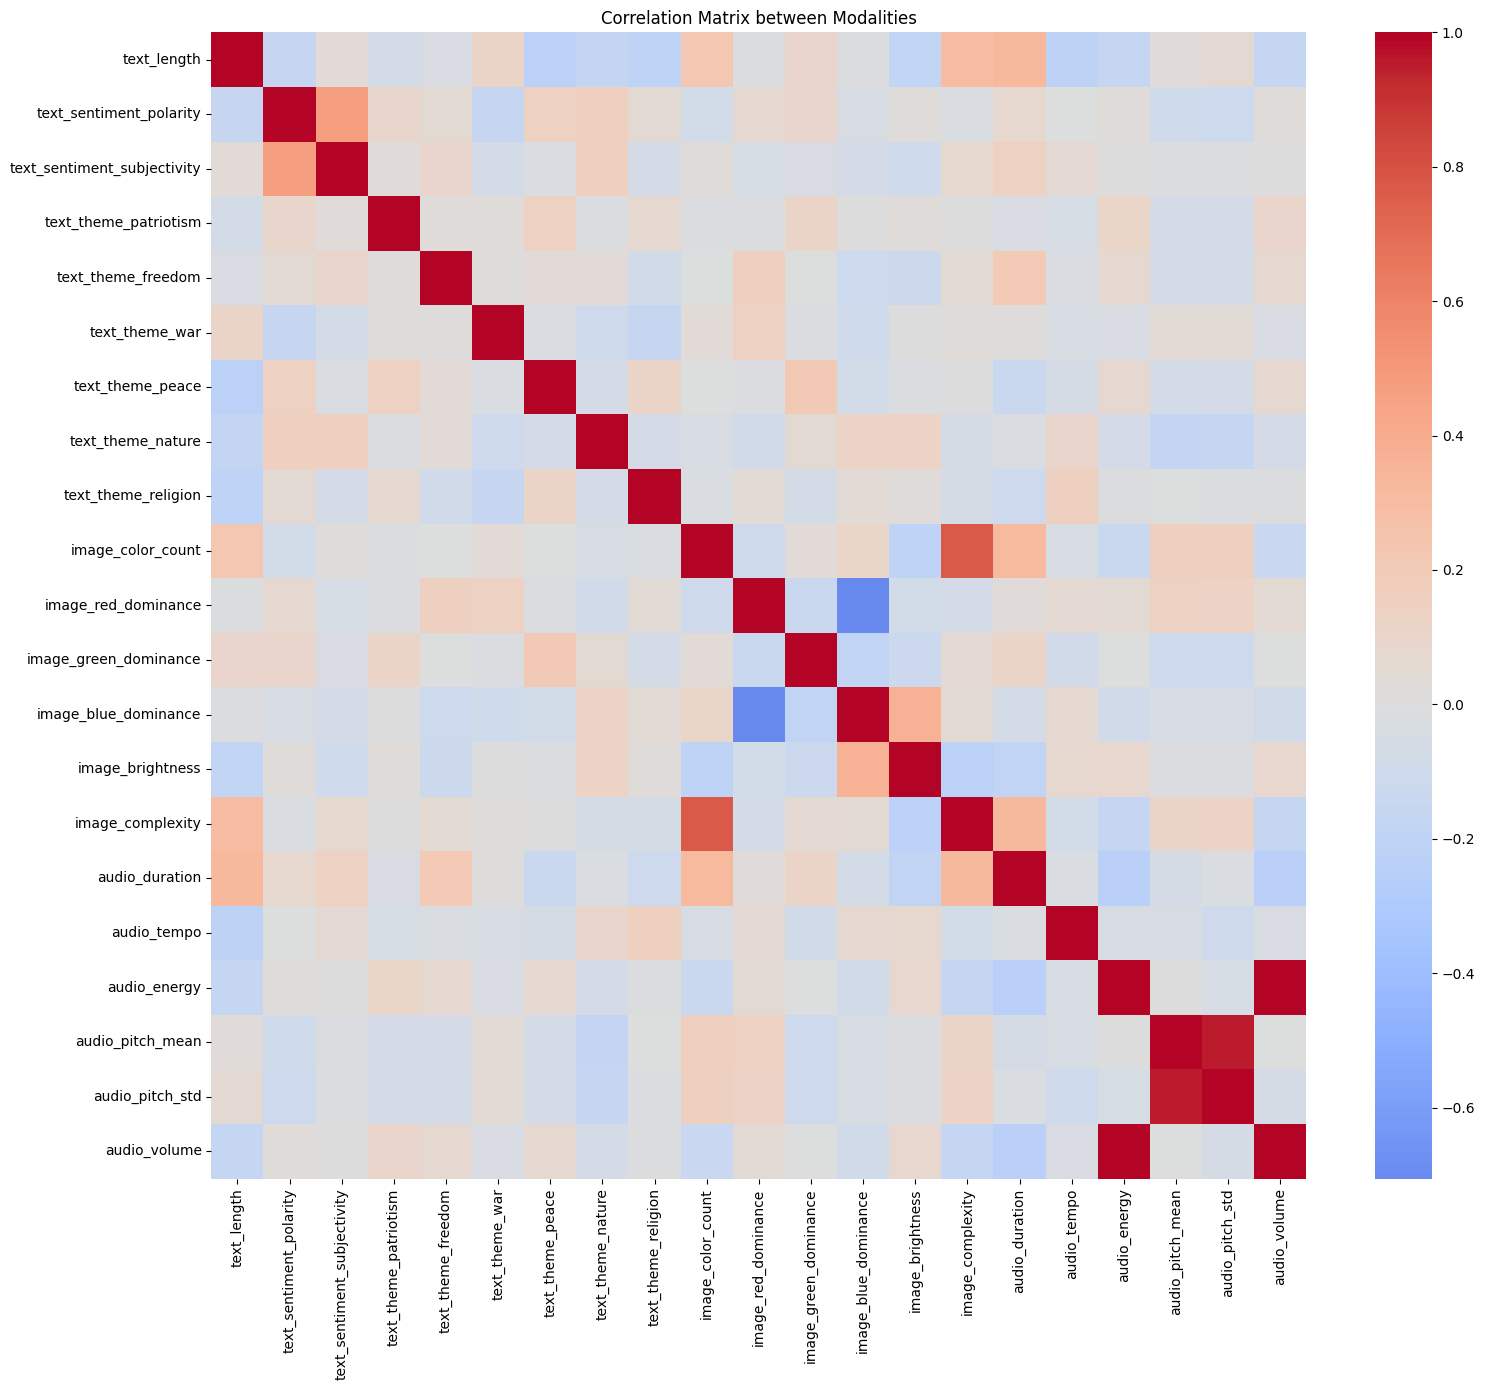


Top correlations between modalities:

text-image correlations:
  text_length ~ image_complexity: 0.31


<Figure size 640x480 with 0 Axes>

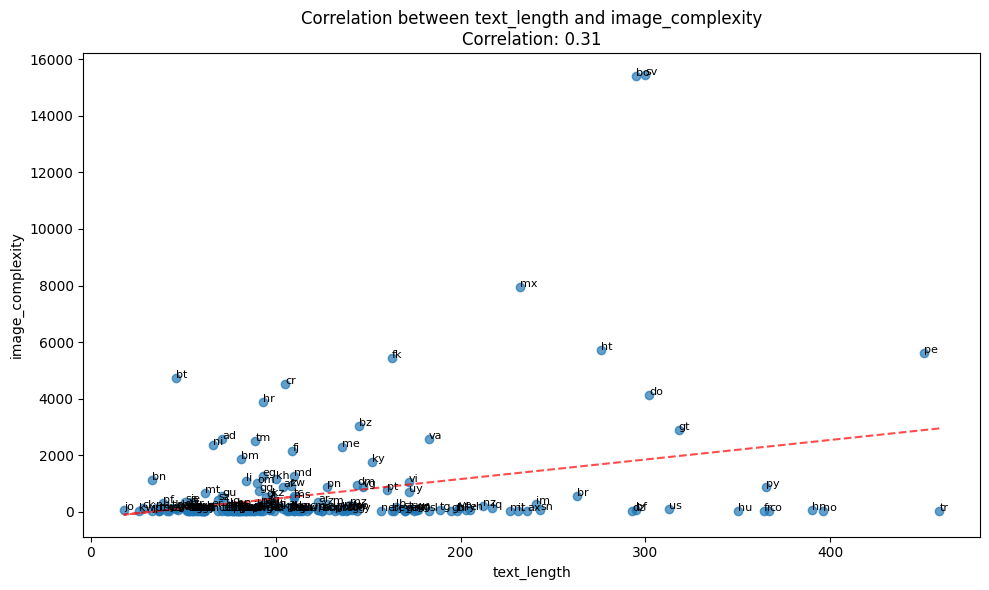

  text_length ~ image_color_count: 0.23


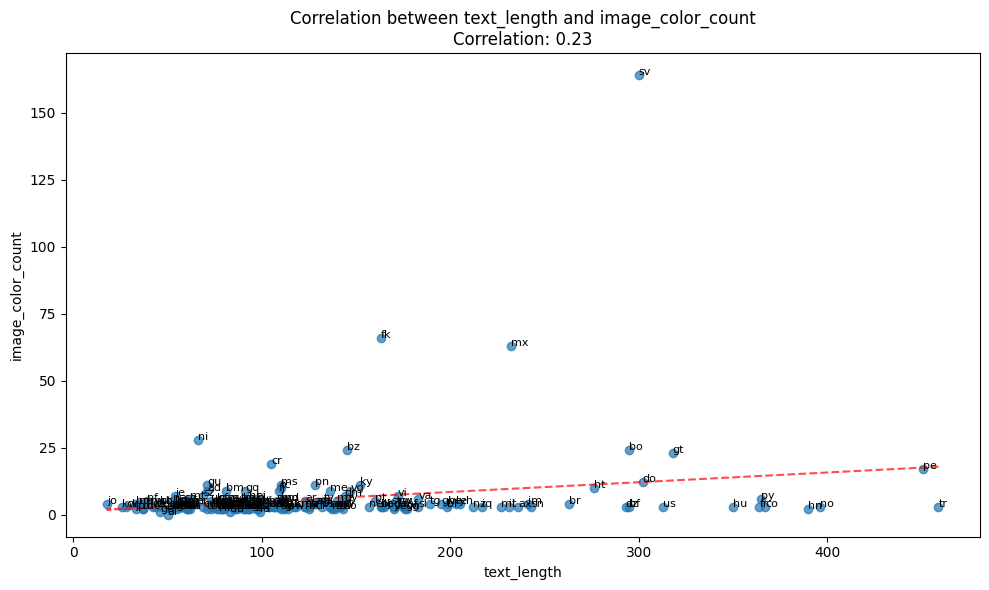

  text_theme_peace ~ image_green_dominance: 0.22


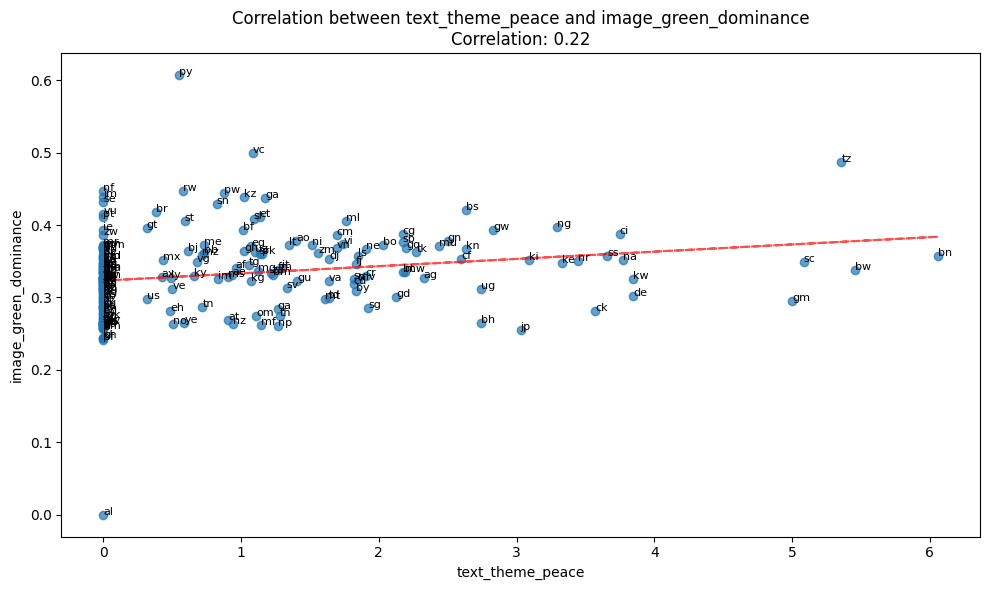


text-audio correlations:
  text_length ~ audio_duration: 0.32


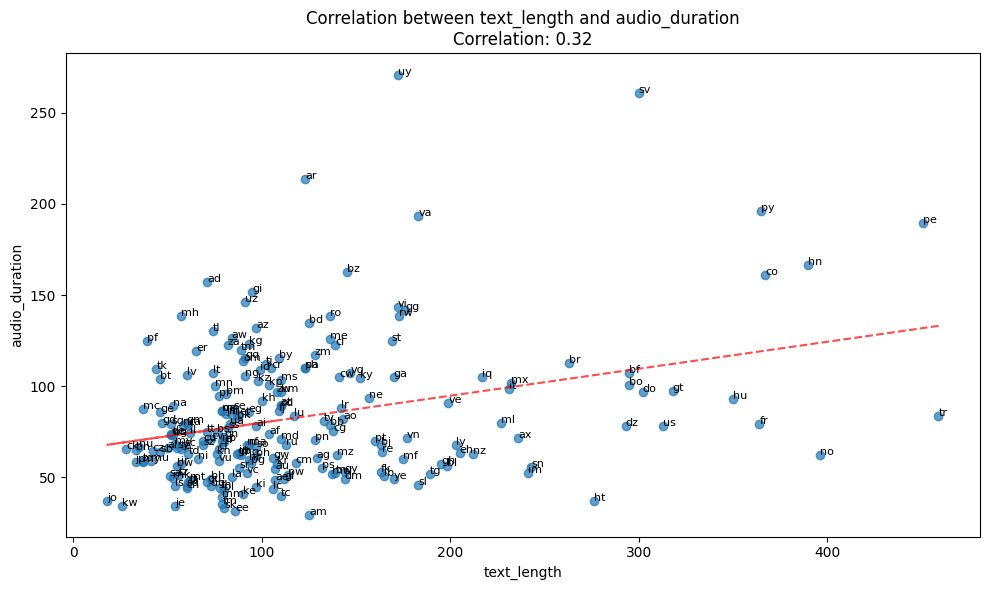

  text_length ~ audio_tempo: -0.21


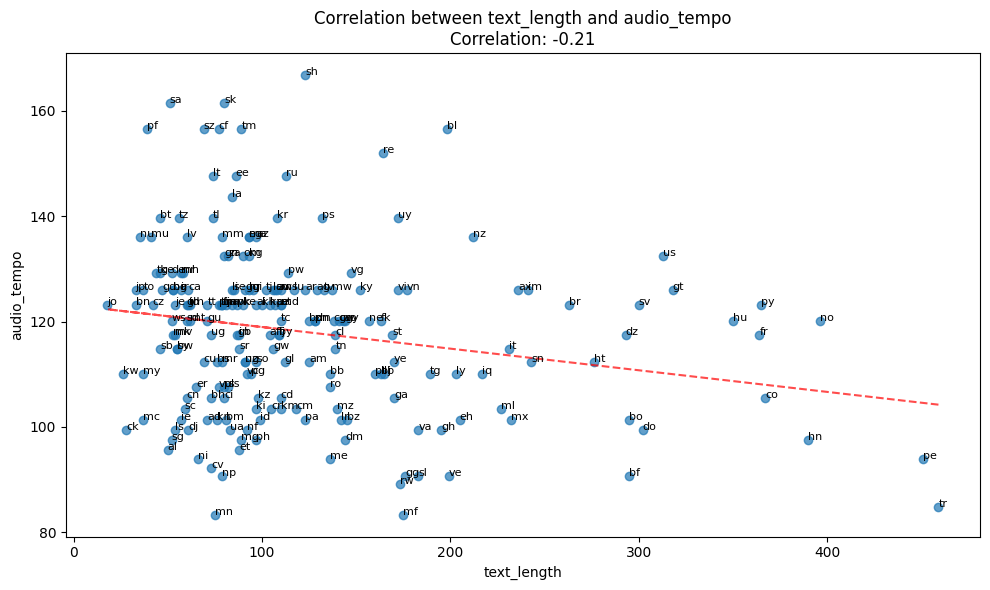

  text_theme_freedom ~ audio_duration: 0.20


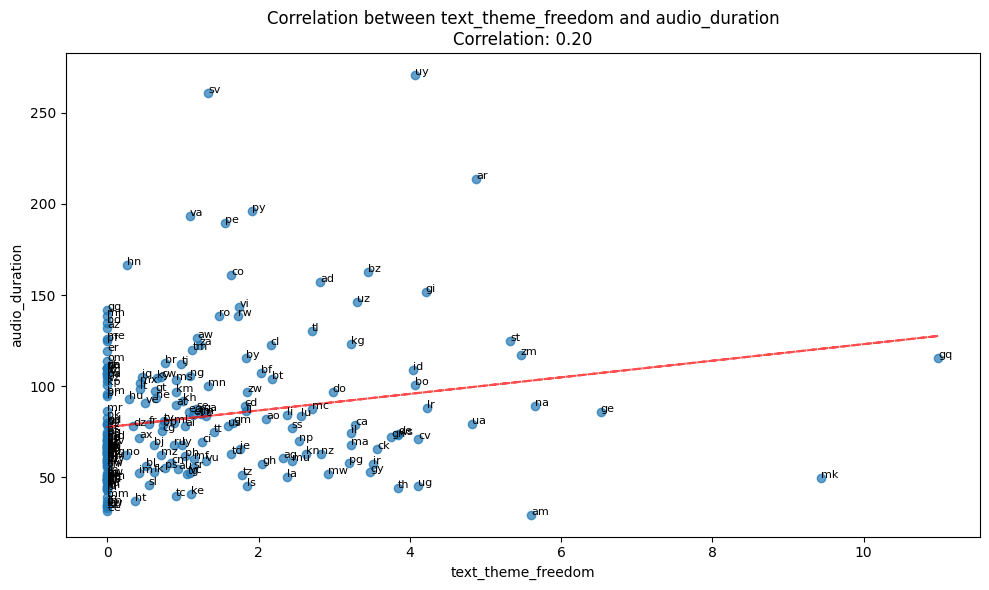


image-audio correlations:
  image_complexity ~ audio_duration: 0.32


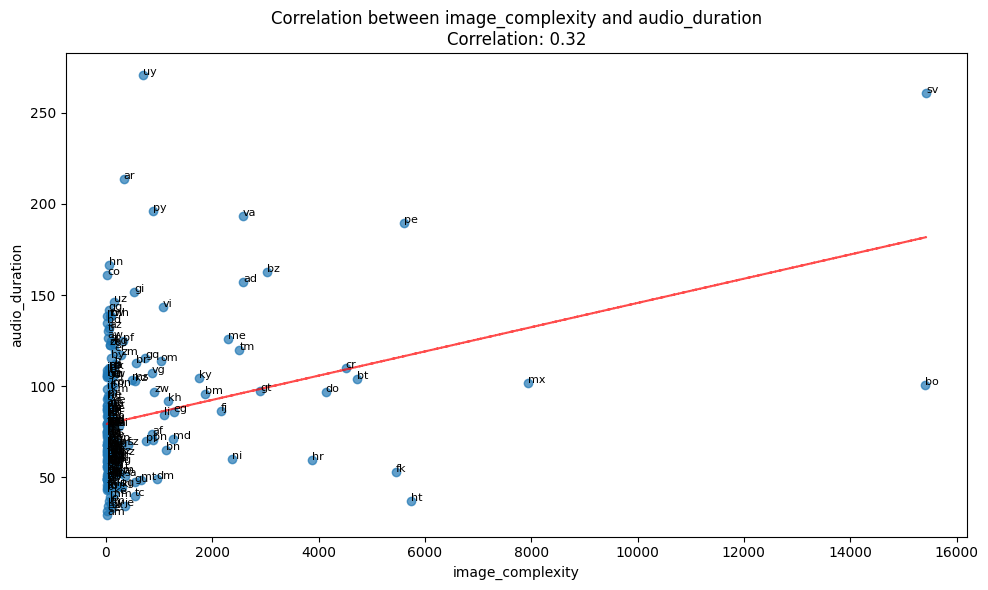

  image_color_count ~ audio_duration: 0.32


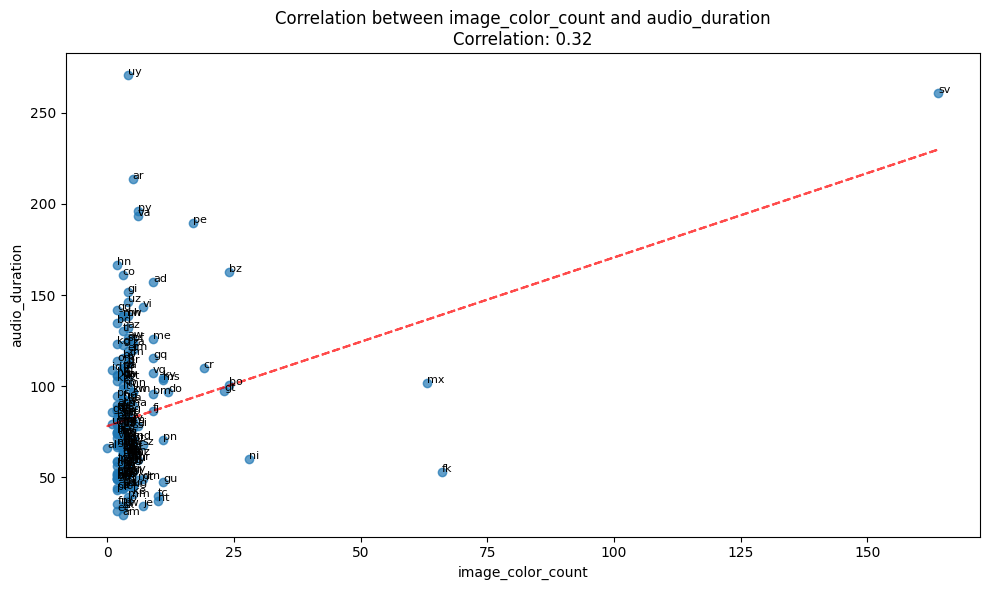

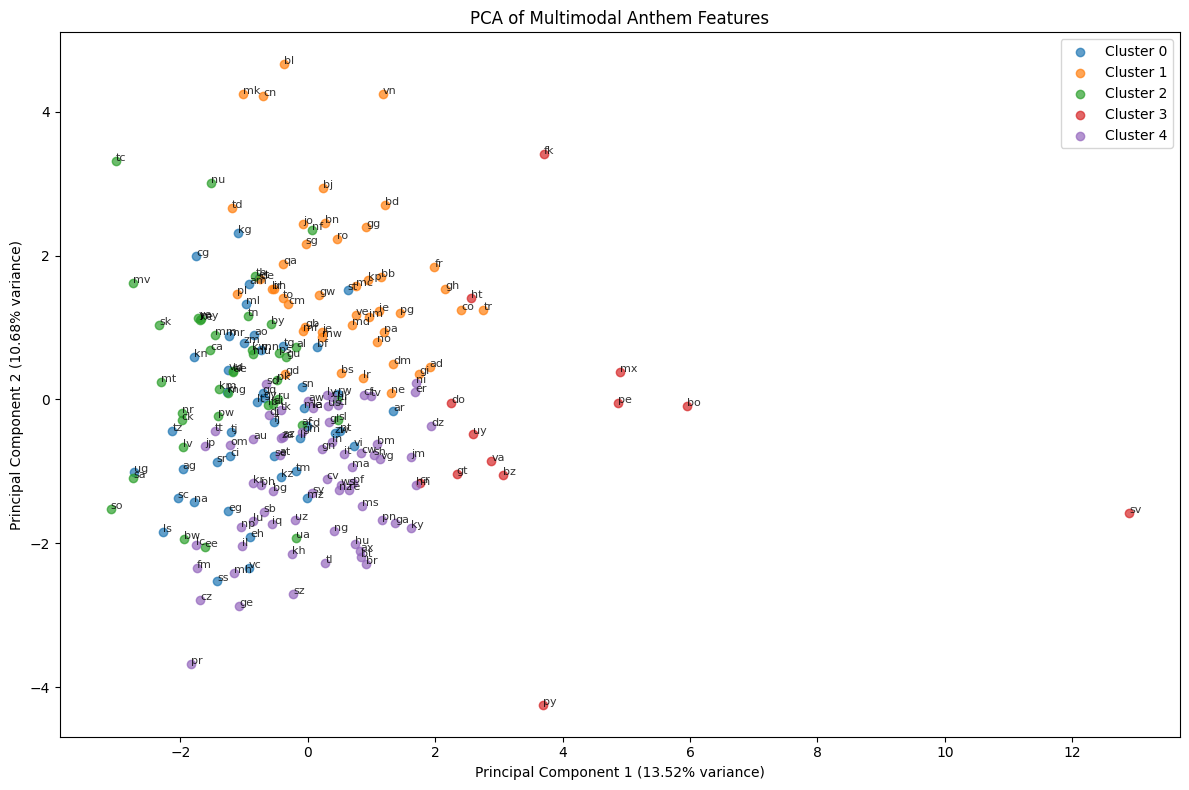


Multimodal clusters:
Cluster 0: cd, kg, me, sr, ug...
Cluster 1: tr, gb, pl, cn, ve...
Cluster 2: ae, mv, al, ru, mu...
Cluster 3: bz, cr, sv, do, py...
Cluster 4: ph, er, lc, sb, vg...

Cross-modal prediction results:
Predicting image_red_dominance from audio features:
  Mean R² score: -0.044
  Cross-validation scores: ['0.051', '-0.057', '-0.018', '-0.141', '-0.056']
Predicting audio_tempo from image features:
  Mean R² score: -0.054
  Cross-validation scores: ['-0.062', '-0.173', '0.016', '-0.040', '-0.009']
Predicting image_red_dominance from text features:
  Mean R² score: -0.071
  Cross-validation scores: ['0.018', '-0.039', '0.083', '-0.387', '-0.028']
Predicting audio_tempo from text features:
  Mean R² score: -0.076
  Cross-validation scores: ['-0.098', '-0.016', '0.003', '-0.353', '0.086']
Predicting text_sentiment_polarity from audio features:
  Mean R² score: -0.081
  Cross-validation scores: ['-0.262', '-0.114', '0.007', '0.013', '-0.052']
Predicting text_sentiment_polari

<Figure size 640x480 with 0 Axes>

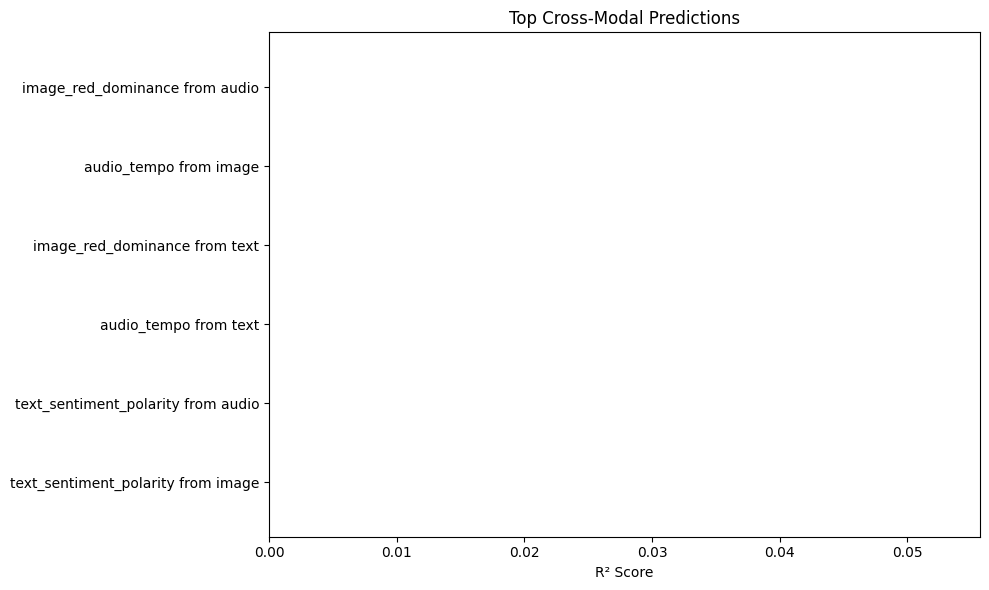

Correlation DF:      text_length  text_sentiment_polarity  text_sentiment_subjectivity  \
tr          459                 0.215427                     0.609154   
gb           87                 0.269481                     0.657143   
ae          107                 0.244545                     0.480000   
ph           97                 0.264286                     0.628571   
er           65                 0.100000                     0.550000   
..          ...                      ...                          ...   
km          110                 0.437500                     0.587500   
cw          141                 0.133333                     0.600000   
lt           74                 0.278571                     0.635714   
ye          170                 0.400000                     0.501786   
au          107                 0.409091                     0.659091   

    text_theme_patriotism  text_theme_freedom  text_theme_war  \
tr               2.614379            1.30

<Figure size 640x480 with 0 Axes>

In [20]:
def main():
    """Main function to run the analysis."""
    print("Starting National Anthem Multimodal Analysis...")
    
    # Create results directory
    os.makedirs(RESULTS_DIR, exist_ok=True)
    
    # Part E: Multimodal Correlation Analysis
    correlation_df, correlation_matrix = analyze_multimodal_correlations()
    print("Correlation DF: ", correlation_df)
    
    print(f"\nAnalysis complete. Results saved to {RESULTS_DIR}")

if __name__ == "__main__":
    main()

#### We notice that the clustered PCA for the multimodality is better clustered with respect to individual modality clusters, as multimodality takes in consideration a wider range of features over different modalities, which leads to a clearer clustering of the anthems of the different countries.